In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, filtfilt
import matplotlib.ticker as ticker

from IPython.display import clear_output

In [2]:
PATH = "/home/gromov_n/MASS/ss2/"

In [3]:
def ReadSignals():
    all_data = {}
    for file in tqdm(os.listdir(PATH)):
        if "PSG" in file:
            data = mne.io.read_raw_edf(PATH + file, verbose=False)
            raw_data = data.get_data()

            labels = np.load("data/" + file + "labels.npy")
            assert len(labels) == len(raw_data[0])
            number = int(file[8:10])
            all_data[number] = [raw_data, labels]
           
            data.close()
    return all_data

In [4]:
all_data = ReadSignals()
assert len(all_data) == 19

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [01:33<00:00,  1.03it/s]


In [5]:
IDS_INVALID = [4, 8, 15, 16]  # Only 1 expert 
IDS_TEST = [13, 12, 2, 6]

In [6]:
def broad_filter(signal, fs, lowcut=0.1, highcut=35):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [7]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        test_data.append(broad_filter(values[0], 256))
        test_labels.append(values[1])
    elif key not in IDS_INVALID:
        train_data.append(broad_filter(values[0], 256))
        train_labels.append(values[1])
assert len(train_data) == 11
assert len(test_data) == 4     

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [01:08<00:00,  3.59s/it]


In [8]:
wavenet_preds = []
for i in range(4):
    wavenet_preds.append(np.load("predicts/preds4000WaveNetADAN" + str(i) + ".npy"))

In [9]:
unet_preds = []
for i in range(4):
    unet_preds.append(np.load("predicts/preds4000UNetADAN" + str(i) + ".npy"))

In [10]:
seed_preds = []
for i in range(4):
    seed_preds.append(np.load("predicts/predsSEED4000_520Overlap" + str(i) + ".npy"))

In [45]:
wavenet_preds[3].argmax() + 20000

184011

In [46]:
unet_preds[3].argmax()

235939

In [47]:
seed_preds[3].argmax()

280656

In [16]:
(12 * 60 + 41) * 60.00384024577573

45662.92242703533

In [19]:
test_labels[3].argmax()

265285

In [30]:
idx = 265285 + 22000

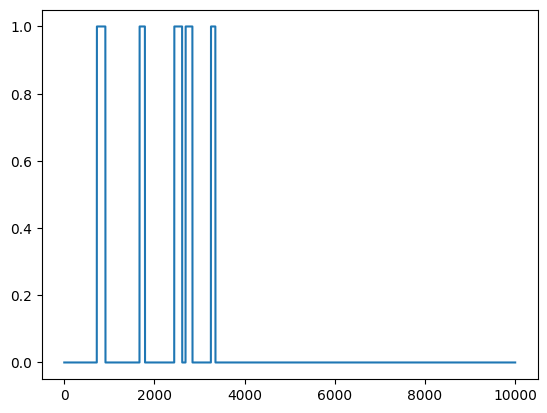

In [65]:
plt.plot(test_labels[3][265285+20000:265285+30000])

In [11]:
def FindFin(seq, start):
    c = 0
    while seq[start + c] == 1:
        c += 1
    return start + c

In [12]:
idx = 265285+21800 - 200

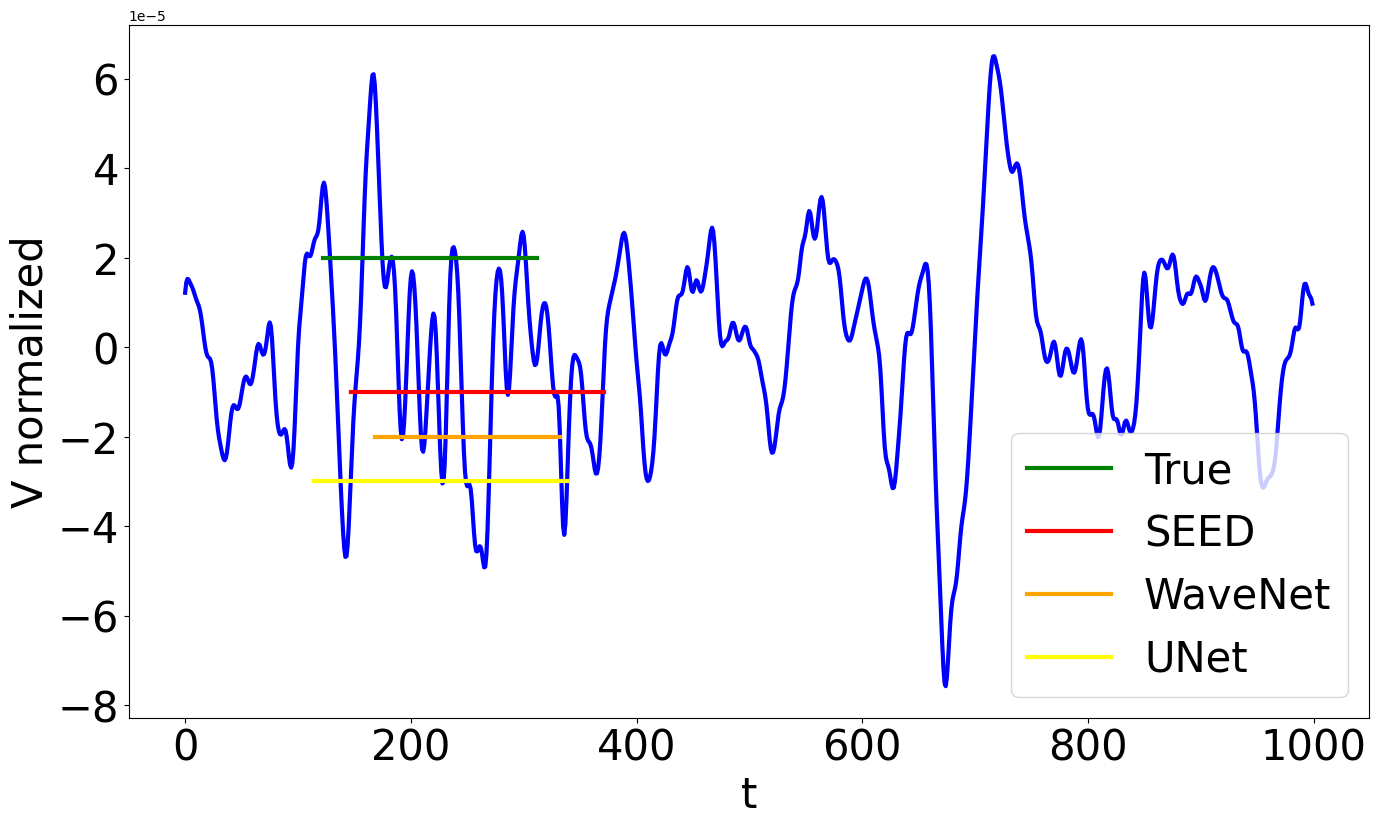

In [14]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(test_data[3][9][idx-1000:idx], c="blue", linewidth=3)
ax.tick_params(axis='both', which='major', labelsize=30)

start = test_labels[3][idx-1000:idx+1000].argmax()
fin = FindFin(test_labels[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [2e-5, 2e-5], label="True", c = "green", linewidth=3)

start = seed_preds[3][idx-1000 - 520:idx+1000 - 520].argmax()
fin = FindFin(seed_preds[3][idx-1000-520:idx+1000-520], start)
ax.plot([start, fin], [-1e-5, -1e-5], label="SEED", c="red", linewidth=3)

start = wavenet_preds[3][idx-1000:idx+1000].argmax()
fin = FindFin(wavenet_preds[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [-2e-5, -2e-5], label="WaveNet", c="orange", linewidth=3)

start = unet_preds[3][idx-1000:idx+1000].argmax()
fin = FindFin(unet_preds[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [-3e-5, -3e-5], label="UNet", c="yellow", linewidth=3)

ax.set_xlabel("t",  fontsize = 30)
ax.set_ylabel("V normalized",  fontsize = 30)
ax.legend(fontsize=30)

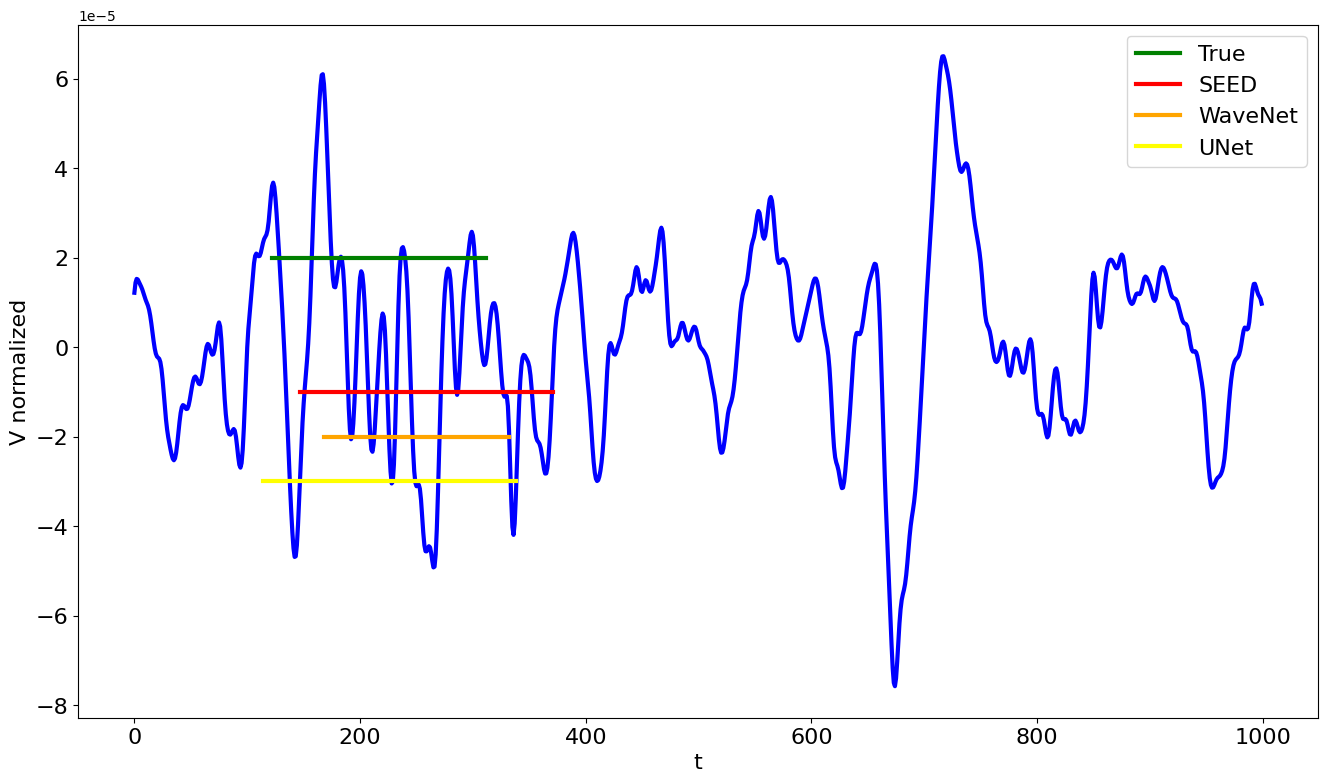

In [103]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(test_data[3][9][idx-1000:idx], c="blue", linewidth=3)
ax.tick_params(axis='both', which='major', labelsize=16)

start = test_labels[3][idx-1000:idx+1000].argmax()
fin = FindFin(test_labels[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [2e-5, 2e-5], label="True", c = "green", linewidth=3)

start = seed_preds[3][idx-1000 - 520:idx+1000 - 520].argmax()
fin = FindFin(seed_preds[3][idx-1000-520:idx+1000-520], start)
ax.plot([start, fin], [-1e-5, -1e-5], label="SEED", c="red", linewidth=3)

start = wavenet_preds[3][idx-1000:idx+1000].argmax()
fin = FindFin(wavenet_preds[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [-2e-5, -2e-5], label="WaveNet", c="orange", linewidth=3)

start = unet_preds[3][idx-1000:idx+1000].argmax()
fin = FindFin(unet_preds[3][idx-1000:idx+1000], start)
ax.plot([start, fin], [-3e-5, -3e-5], label="UNet", c="yellow", linewidth=3)

ax.set_xlabel("t",  fontsize = 16)
ax.set_ylabel("V normalized",  fontsize = 16)
ax.legend(fontsize=16)

In [89]:
idx = 265285+15800


In [ ]:
idx = test_labels[3].argmax()